<a href="https://colab.research.google.com/github/xy2119/Brain_MRI_Image_Segmentation/blob/main/MRI_ImageSeg_U_Net_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Image Segmentation for Brain Tumor | U-Net with Pretrained VGG16
# Winner of the 2021 Imperial College Data Science Challenge

Magnetic resonance imaging (MRI) has made great strides in diagnosing brain injuries and researching brain structure. Brain MRI improvements have provided large amount of data with an increasingly high level of quality. Clinicians must manually extract crucial information from big MRI datasets. Due to inter- or intraoperator variability studies, manual analysis is time-consuming and prone to inaccuracy. To improve diagnostic and testing processes, AI-based automated techniques have been developed to analyse brain MRI data.

In the 2021 **[Data Science Institute](https://www.imperial.ac.uk/data-science/) Computer Vision Challenge**, a dataset of brain MRIs from patients with glioma was made available. We aim to apply semantic segmentation techniques to aid in the diagnosis of brain tumours.

**[Prof. Yike Guo](https://www.imperial.ac.uk/people/y.guo)**, co-director of the Data Science Institute, recognised our work as the "**Best Computer Vision Project**". Since our model achieved the **highest accuracy (80%)** in the testing tasks, which uses a U-net architecture with a pretrained VGG16 and was trained on 90% of available data.

This notebook is organised as follows:

0. Install and Import Libraries
1. Load Raw Data From Drive
2. Visualise MRI 2D Image and Segmentation Maps
3. Create Images and Masks Dataset
4. U-Net Architecture with Pretrained VGG16
5. Model Training
6. Ready for Testing




Some information may be helpful before you repreducing this notebook:


* I track my training using `wandb`. `wandb` is a tool for tracking and visualising machine learning experiments in real time on [Weights & Biases](https://wandb.ai) platform. Create an account and experiment with the interactive dashboards! If you already have an account, that's fantastic! To monitor this experiment, launch the notebook and paste your API key from your profile.


* I import the raw data from Google Drive; the dataset URL is available [here](https://drive.google.com/drive/folders/1Y4MUrrfT-Xuos83nOnq8ZWTMZmp9qADH?usp=sharing).






## Install and Import Libraries

In [ ]:
%%capture
!pip install wandb
!pip install SimpleITK
!pip install torch-snippets

In [ ]:
import torch
from torch_snippets import *
from torchvision import transforms
from torchvision.models import vgg19_bn
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import random
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from skimage import io, transform

In [ ]:
# wandb login
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Wandb configuration
class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3
    N_EPOCHS = 5

# Set config
WANDB_CONFIG = {'_wandb_kernel': 'neuracort'}

# Initialize W&B
run = wandb.init(
    project='semantic_segmentation_unet', 
    config= WANDB_CONFIG
)

wandb: Currently logged in as: xy2119 (fancykid). Use `wandb login --relogin` to force relogin


## Load Raw Data From Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualise MRI 2D Image and Segmentation Maps



Each MRI image contains information about a three-dimensional (3D) volume of space. An MRI image is composed of a number of voxels, which is like pixels in 2D images. The transverse plane of the volumes and the corresponding segmentation maps (masks) are visualised. 



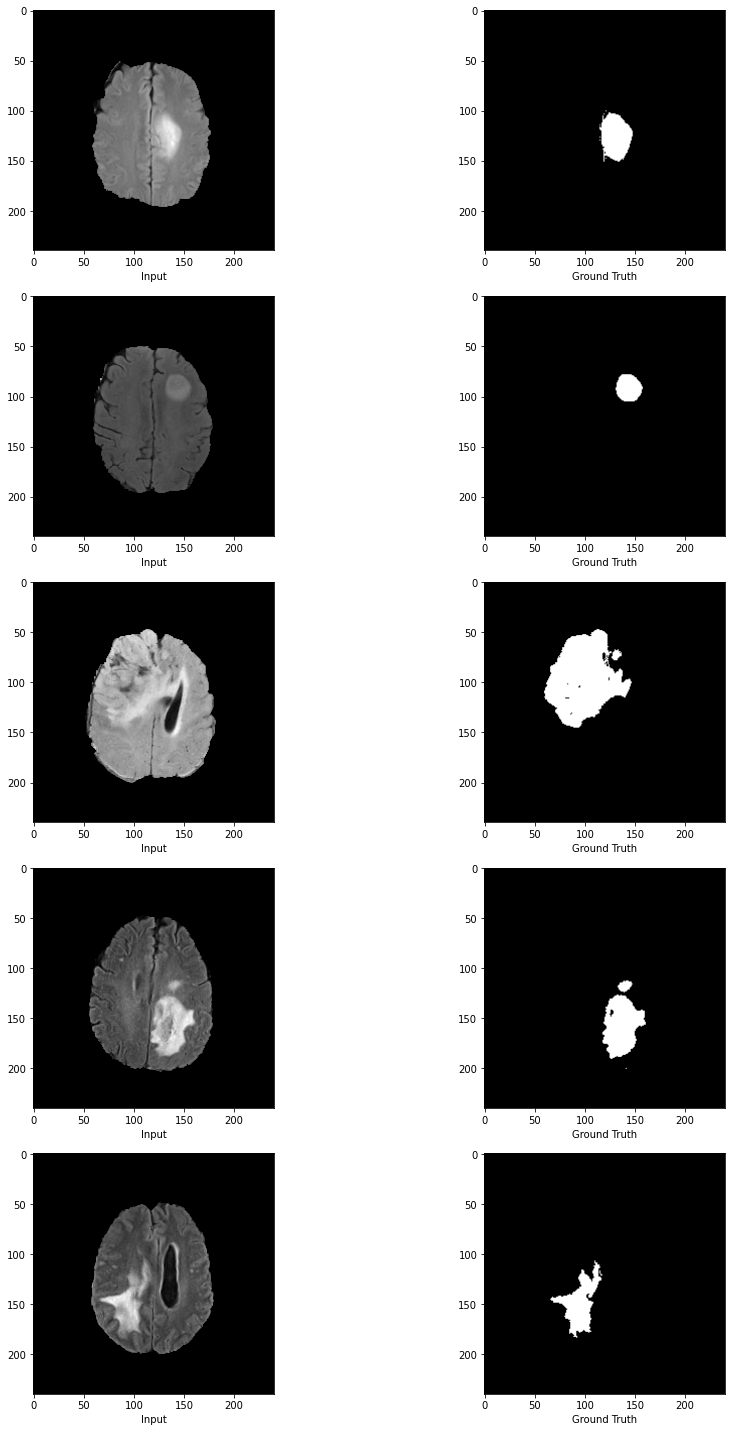

In [ ]:
def plot_samples(paths, files, n=10):
    i = n
    j = 2
    plt.figure(figsize=(15,20))
    k = 1
    idx_nums = np.random.randint(len(files),size=n)
    for idx in idx_nums:
        plt.subplot(i,j,k)
        while k%2 != 0:
            # MRI images 
            img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(paths,files[idx],f'{files[idx]}_fla.nii'))) 
            plt.imshow(img[100,:,:], cmap='gray')
            plt.xlabel("Input")
            k += 1
        plt.subplot(i,j,k)
        # Segmentation maps 
        seg = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(paths,files[idx],f'{files[idx]}_seg.nii')))
        plt.imshow(seg[100,:,:], cmap='gray')
        plt.xlabel("Ground Truth")
        k += 1
    plt.tight_layout()
    plt.show()
files_path = '/content/drive/MyDrive/Dataset/seg'
files_lst = os.listdir(files_path)
plot_samples(files_path, files_lst, n=5)

## Create Dataloader for Images and Masks

In [ ]:
## Create MRI_data Dataset Class
class MRI_data(Dataset):
    def __init__(self,path):
        self.path = path
        self.patients = [item for item in all_files if "img" in item]
        self.masks,self.images = [],[]

        for (n, file_name) in enumerate(self.patients): 
          img = os.path.join(path,CLASS,file_name)
          seg = os.path.join(path,CLASS,file_name.split('_')[0]+'_seg.npy')
          
          self.images.append(np.load(img))
          self.masks.append(np.load(seg))
                
        self.images = np.array(self.images)
        self.masks = np.array(self.masks)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # resize to 256 * 256, remember to transform in the test task
        image = transform.resize(image,(256,256)) 
        image = image / 255
        image = image.transpose((2, 0, 1,))
        
        # resize to 256 * 256 
        mask = transform.resize(mask,(256,256)) 
        mask = mask / 255
        mask = np.expand_dims(mask,axis=-1).transpose((2, 0, 1))

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        return image,mask

    def choose(self): return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))

        ims = torch.cat([(im) for im in ims]).float().to(config.DEVICE)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(config.DEVICE)
        return ims, ce_masks   

In [ ]:
path = '/content/drive/MyDrive/Dataset/'
CLASS = 'Yes'
all_files = os.listdir(path + CLASS)

# Load image and mask as Dataset Class 
data = MRI_data(path)

print('Length of dataset is {}'. format(data.__len__()))

Length of dataset is 3319

In [ ]:
# Check image size and mask size
for img,msk in data:
    print(img.shape)
    print(msk.shape)
    break

torch.Size([3, 256, 256])

torch.Size([1, 256, 256])

In [ ]:
def collate_fn(batch):
  ims, masks = list(zip(*batch))
  
  ims = torch.cat([(im/255) for im in ims]).float().to(config.DEVICE)

  ce_masks = torch.cat([torch.Tensor(mask) for mask in masks]).long().to(config.DEVICE)

  return ims, ce_masks   
  
def get_dataloaders():
  trn_ds, val_ds = random_split(data, [2987, 332]) # train : test = 9:1

  trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)
  val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)

  return trn_dl, val_dl

# get image and mask dataloader 
trn_dl, val_dl = get_dataloaders()

## U-Net Architecture with Pretrained VGG16

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, pretrained=True,out_channels=12,):
        super().__init__()
        # Pre-trained VGG16 Model
        self.encoder = vgg16_bn(weights=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
     
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [ ]:
# Define Loss Function
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
# Engine 
class engine():
  def train_batch(model, data, optimizer, criterion):
      model.train()

      ims, ce_masks = data
      ims=ims.unsqueeze(0)
      _masks = model(ims)
      optimizer.zero_grad()

      loss, acc = criterion(_masks, ce_masks)
      loss.backward()
      optimizer.step()

      return loss.item(), acc.item()

  @torch.no_grad()
  def validate_batch(model, data, criterion):
      model.eval()

      ims, masks = data
      ims=ims.unsqueeze(0)
      _masks = model(ims)

      loss, acc = criterion(_masks, masks)

      return loss.item(), acc.item()

In [ ]:
def make_model():
  model = UNet().to(config.DEVICE)
  criterion = UnetLoss
  optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  return model, criterion, optimizer

model, criterion, optimizer = make_model()

## Model Training

In [ ]:
def run():
  for epoch in range(config.N_EPOCHS):
      print("####################")
      print(f"       Epoch: {epoch}   ")
      print("####################")

      for bx, data in tqdm(enumerate(trn_dl), total = len(trn_dl)):
          train_loss, train_acc = engine.train_batch(model, data, optimizer, criterion)

      for bx, data in tqdm(enumerate(val_dl), total = len(val_dl)):
          val_loss, val_acc = engine.validate_batch(model, data, criterion)

      wandb.log(
          {   
              'epoch': epoch,
              'train_loss': train_loss,
              'train_acc': train_acc,
              'val_loss': val_loss,
              'val_acc': val_acc
          }
      )

      print()

In [ ]:
run()

####################

Epoch: 0

####################

100%|██████████| 319/319 [00:21<00:00, 14.89it/s]


####################

Epoch: 1

####################

100%|██████████| 319/319 [00:18<00:00, 17.23it/s]


####################

Epoch: 2

####################

100%|██████████| 319/319 [00:21<00:00, 14.74it/s]


####################

Epoch: 3

####################

100%|██████████| 319/319 [00:21<00:00, 14.74it/s]


####################

Epoch: 4

####################

100%|██████████| 319/319 [00:16<00:00, 19.52it/s]


In [ ]:
# Save model for submission
torch.save(model.state_dict(), '/trained_unet.hdf5')

In [ ]:
# or save a scripted version
model_scripted = torch.jit.script(model) 
model_scripted.save('trained_unet_scripted.pt') 

## Ready for Testing 


In [ ]:
PATH= '/content/trained_unet.hdf5'
model = UNet()
model.load_state_dict(torch.load(PATH))
model.eval()

UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256